### Upload DATA_1 zip folder to files 
### Run following commands to train the network

In [ ]:
!unzip DATA_1.zip

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import cv2
import pandas as pd
import ntpath
import random

In [3]:
datadir = 'DATA_1'
class CarDataPreprocessor:
 
    def __init__(self):
      data_cols = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
      self.data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = data_cols)
      # self.data = pd.read_csv('driving_log.csv', names = data_cols)
      pd.set_option('display.max_colwidth', -1)

      self.data['center'] = self.data['center'].apply(self.path_node)
      self.data['left'] = self.data['left'].apply(self.path_node)
      self.data['right'] = self.data['right'].apply(self.path_node)

      self.bins_count = 25
      self.samples = 400
      self.center = 0
      self.bins = 0

    def path_node(self, path):
      head, tail = ntpath.split(path)
      return tail

    def display_total_data(self):
      hist, self.bins = np.histogram(self.data['steering'], self.bins_count)
      self.center = (self.bins[:-1]+ self.bins[1:]) * 0.5
      plt.bar(self.center, hist, width=0.05)
      plt.plot((np.min(self.data['steering']), np.max(self.data['steering'])), (self.samples, self.samples))
      print('total data:', len(self.data))

    def drop_outlier_data(self):
      remove_list = []
      for j in range(self.bins_count):
        list_ = []
        for i in range(len(self.data['steering'])):
          if self.data['steering'][i] >= self.bins[j] and self.data['steering'][i] <= self.bins[j+1]:
            list_.append(i)
        list_ = shuffle(list_)
        list_ = list_[self.samples:]
        remove_list.extend(list_)
      self.data.drop(self.data.index[remove_list], inplace=True)

      hist, _ = np.histogram(self.data['steering'], (self.bins_count))
      plt.bar(self.center, hist, width=0.05)
      plt.plot((np.min(self.data['steering']), np.max(self.data['steering'])), (self.samples, self.samples))
    
    def load_images_and_steering(self, datadir):
      image_path = []
      steering = []
      for i in range(len(self.data)):
        indexed_data = self.data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
      image_paths = np.asarray(image_path)
      steerings = np.asarray(steering)
      return image_paths, steerings
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


total data: 7671
Training Samples: 9612
Valid Samples: 2403


Text(0.5, 1.0, 'Validation set')

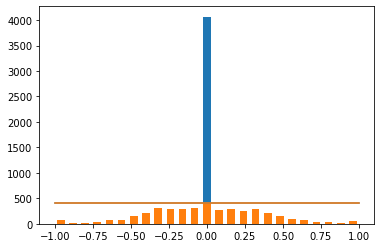

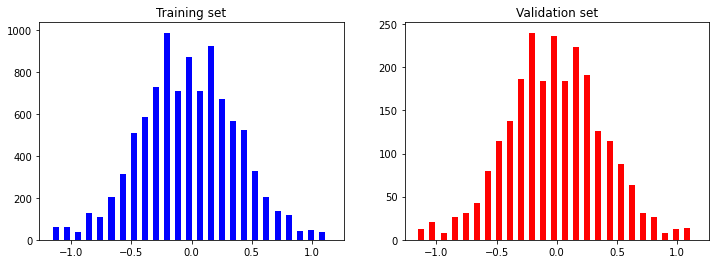

In [4]:
cdp = CarDataPreprocessor()
cdp.display_total_data()
cdp.drop_outlier_data()
image_paths, steerings = cdp.load_images_and_steering(datadir + '/IMG')

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=cdp.bins_count, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=cdp.bins_count, width=0.05, color='red')
axes[1].set_title('Validation set')

In [5]:
class ImagePreprocessor:
  def __init__(self):
    pass
  
  def zoom(self, image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

  def pan(self, image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

  def img_random_brightness(self, image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

  def img_random_flip(self, image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

  def random_augment(self, image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = self.pan(image)
    if np.random.rand() < 0.5:
      image = self.zoom(image)
    if np.random.rand() < 0.5:
      image = self.img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = self.img_random_flip(image, steering_angle)
    
    return image, steering_angle

  def image_preprocess(self, image):
    image = image[60:135,:,:]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image = cv2.GaussianBlur(image,  (3, 3), 0)
    image = cv2.resize(image, (200, 66))
    image = image/255
    return image

  def display_preprocessed(original_image, preprocessed_image):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[1].imshow(preprocessed_image)
    axes[1].set_title('Preprocessed Image')


In [8]:
image_precessor = ImagePreprocessor()

def batch_data(image_paths, steering_angle, batch_size, is_training):
  while True:
    image_batch = []
    steering_batch = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if is_training:
        img, steering = image_precessor.random_augment(image_paths[random_index], steering_angle[random_index])
     
      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_angle[random_index]
      
      img = image_precessor.image_preprocess(img)
      image_batch.append(img)
      steering_batch.append(steering)
    yield (np.asarray(image_batch), np.asarray(steering_batch))  

In [9]:
x_train_gen, y_train_gen = next(batch_data(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_data(X_valid, y_valid, 1, 0))

In [10]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, 5, 5, padding='same', input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, 5, 5, padding='same', activation='elu'))
  model.add(Conv2D(48, 5, 5, padding='same', activation='elu'))
  model.add(Conv2D(64, 3, 3, padding='same', activation='elu'))
  
  model.add(Conv2D(64, 3, 3, padding='same', activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 40, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 8, 36)          21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 2, 48)          43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 64)          27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 64)          36928     
                                                                 
 dropout (Dropout)           (None, 1, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(batch_data(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=50,
                                  validation_data=batch_data(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('DATA_1.h5')
from google.colab import files
files.download('DATA_1.h5')